In [3]:
!pip install torch_summary
!pip install captum

  Using cached torch_summary-1.4.5-py3-none-any.whl (16 kB)
  Using cached captum-0.5.0-py3-none-any.whl (1.4 MB)


# Import Libraries

In [4]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm.notebook import tqdm 

from sklearn.metrics import classification_report
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle, randint, choice
import numpy as np
import cv2
from glob import glob
import pandas as pd
import numpy as np
from captum.attr import Occlusion, visualization as viz

In [5]:
!mkdir saved_model
sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data

In [6]:
DIR = '../input/140k-real-and-fake-faces/'
test_df = pd.read_csv(f'{DIR}test.csv', index_col=0)
test_df.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg


In [7]:
def label_split(df, size, fake_size, random_state=4012):
    real_size = 1 - fake_size
    real_size = int(real_size * size)
    fake_size = int(fake_size * size)
    fake_df = df[df['label'] == 0]
    real_df = df[df['label'] == 1]
    sub_fake_df = fake_df.sample(fake_size, random_state=random_state)
    sub_real_df = real_df.sample(real_size, random_state=random_state)
    new_df = pd.concat([sub_fake_df, sub_real_df])
    new_df = new_df.sample(frac=1, random_state=random_state)
    return new_df.reset_index(drop=True)

In [8]:
test_df = label_split(test_df, 2500, 0.05)

<BarContainer object of 2 artists>

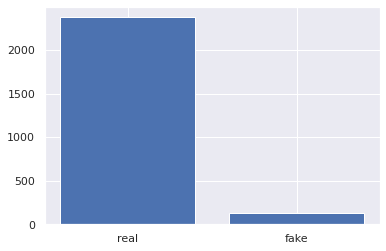

In [9]:
test_label = test_df['label_str'].value_counts()
plt.bar(test_label.index, test_label.values)

In [10]:
class FaceInceptionDataset(Dataset):
    def __init__(self, df, DIR="../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/"):
        super().__init__()
        self.df = df
        self.DIR = DIR
        self.transform = T.Compose([
            T.Resize([299, 299]),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), 
                        (0.229, 0.224, 0.225))
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ind):
        row = self.df.iloc[ind]
        img_path = self.DIR + row['path']
        img = Image.open(img_path).convert('RGB')
        target = row['label']
        return img, target
    
    def get_real_img(self):
        real_img_ind = self.df[self.df['label'] == 1].index
        target_ind = choice(real_img_ind)
        return self[target_ind]
    
    def get_fake_img(self):
        real_img_ind = self.df[self.df['label'] == 0].index
        target_ind = choice(real_img_ind)
        return self[target_ind]
    
    def choose(self):
        return self[randint(0, len(self)-1)]
    
    def decode(self, target):
        return ['fake', 'real'][target]
    
    def transform_img(self, img):
        return self.transform(img)
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        targets = torch.tensor(targets)
        targets = targets.view(-1, 1).float()
        imgs = torch.stack(
            [self.transform_img(img) for img in imgs], 0
        )
        return imgs.to(device), targets.to(device)

In [11]:
class FaceResNetDataset(Dataset):
    def __init__(self, df, DIR="../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/"):
        super().__init__()
        self.df = df
        self.DIR = DIR
        self.transform = T.Compose([
            T.Resize([224, 224]),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), 
                        (0.229, 0.224, 0.225))
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ind):
        row = self.df.iloc[ind]
        img_path = self.DIR + row['path']
        img = Image.open(img_path).convert('RGB')
        target = row['label']
        return img, target
    
    def get_real_img(self):
        real_img_ind = self.df[self.df['label'] == 1].index
        target_ind = choice(real_img_ind)
        return self[target_ind]
    
    def get_fake_img(self):
        real_img_ind = self.df[self.df['label'] == 0].index
        target_ind = choice(real_img_ind)
        return self[target_ind]
    
    def choose(self):
        return self[randint(0, len(self)-1)]
    
    def decode(self, target):
        return ['fake', 'real'][target]
    
    def transform_img(self, img):
        return self.transform(img)
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        targets = torch.tensor(targets)
        targets = targets.view(-1, 1).float()
        imgs = torch.stack(
            [self.transform_img(img) for img in imgs], 0
        )
        return imgs.to(device), targets.to(device)

In [12]:
test_incep_ds = FaceInceptionDataset(test_df)
test_incep_dl = DataLoader(test_incep_ds, batch_size=64,
                           collate_fn=test_incep_ds.collate_fn)
test_res_ds = FaceResNetDataset(test_df)
test_res_dl = DataLoader(test_res_ds, batch_size=64,
                         collate_fn=test_res_ds.collate_fn)

In [13]:
print('Size of Test:', len(test_incep_ds))

Size of Test: 2500


## Model

## Base

In [14]:
class BaseFaceInceptionClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = models.inception_v3(pretrained=pretrained, progress=pretrained)
        for param in self.backbone.parameters():
            param.requires_grad = True
        
        aux_num_features = self.backbone.AuxLogits.fc.in_features
        self.backbone.AuxLogits.fc = nn.Sequential(
            nn.Linear(aux_num_features, 1),
            nn.Sigmoid()
        )
        
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [15]:
base_incep_classifier = BaseFaceInceptionClassifier(pretrained=False)
_ = summary(base_incep_classifier, torch.ones(1,3,299,299))

/opt/conda/lib/python3.7/site-packages/torchvision/models/inception.py:48: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


Layer (type:depth-idx)                   Output Shape              Param #
├─Inception3: 1-1                        [-1, 1]                   --
|    └─BasicConv2d: 2-1                  [-1, 32, 149, 149]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 149, 149]        864
|    |    └─BatchNorm2d: 3-2             [-1, 32, 149, 149]        64
|    └─BasicConv2d: 2-2                  [-1, 32, 147, 147]        --
|    |    └─Conv2d: 3-3                  [-1, 32, 147, 147]        9,216
|    |    └─BatchNorm2d: 3-4             [-1, 32, 147, 147]        64
|    └─BasicConv2d: 2-3                  [-1, 64, 147, 147]        --
|    |    └─Conv2d: 3-5                  [-1, 64, 147, 147]        18,432
|    |    └─BatchNorm2d: 3-6             [-1, 64, 147, 147]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 73, 73]          --
|    └─BasicConv2d: 2-5                  [-1, 80, 73, 73]          --
|    |    └─Conv2d: 3-7                  [-1, 80, 73, 73]          5,120
|  

In [16]:
class BaseFaceResNetClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.resnet34(pretrained=pretrained, progress=pretrained)
        for param in self.model.parameters():
            param.requires_grad = True
        
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
base_res_classifier = BaseFaceResNetClassifier(pretrained=False)
_ = summary(base_res_classifier, torch.ones(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-3              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-5              [-1, 128, 28, 28]         295,424
|    |    └─BasicBlock: 3-6              [-1, 128, 28, 28] 

## Fine-Tuned

In [18]:
class FTFaceInceptionClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = models.inception_v3(pretrained=pretrained, progress=pretrained)
        for param in self.backbone.parameters():
            param.requires_grad = True
        
        aux_num_features = self.backbone.AuxLogits.fc.in_features
        self.backbone.AuxLogits.fc = nn.Sequential(
            nn.BatchNorm1d(aux_num_features),
            nn.Dropout(0.2),
            nn.Linear(aux_num_features, 1),
            nn.Sigmoid()
        )
        
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.2),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [19]:
ft_incep_classifier = FTFaceInceptionClassifier()
_ = summary(ft_incep_classifier, torch.ones(1,3,299,299))

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
├─Inception3: 1-1                        [-1, 1]                   --
|    └─BasicConv2d: 2-1                  [-1, 32, 149, 149]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 149, 149]        864
|    |    └─BatchNorm2d: 3-2             [-1, 32, 149, 149]        64
|    └─BasicConv2d: 2-2                  [-1, 32, 147, 147]        --
|    |    └─Conv2d: 3-3                  [-1, 32, 147, 147]        9,216
|    |    └─BatchNorm2d: 3-4             [-1, 32, 147, 147]        64
|    └─BasicConv2d: 2-3                  [-1, 64, 147, 147]        --
|    |    └─Conv2d: 3-5                  [-1, 64, 147, 147]        18,432
|    |    └─BatchNorm2d: 3-6             [-1, 64, 147, 147]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 73, 73]          --
|    └─BasicConv2d: 2-5                  [-1, 80, 73, 73]          --
|    |    └─Conv2d: 3-7                  [-1, 80, 73, 73]          5,120
|  

In [20]:
class FTFaceResNetClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.resnet34(pretrained=pretrained, progress=pretrained)
        for param in self.model.parameters():
            param.requires_grad = True
        
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.2),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [21]:
ft_res_classifier = FTFaceResNetClassifier()
_ = summary(ft_res_classifier, torch.ones(1,3,224,224))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-3              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-5              [-1, 128, 28, 28]         295,424
|    |    └─BasicBlock: 3-6              [-1, 128, 28, 28] 

# Evaluation

In [22]:
def evaluate(classifier, weight_path, dl):
    weights = torch.load(weight_path)
    classifier.load_state_dict(weights)
    classifier.eval()
    outputs_list = []
    targets_list = []

    for i, data in tqdm(enumerate(dl), total=len(dl), desc="Evaluating"):
        imgs, targets = data
        outputs = classifier(imgs)
        outputs_list.extend(outputs.cpu().detach().tolist())
        targets_list.extend(targets.cpu().detach().tolist())

    pred = list(map(lambda x: int(x[0] > 0.5), outputs_list))
    tar = list(map(lambda x: x[0], targets_list))
    print(classification_report(tar, pred))

In [23]:
BASE_RESNET_BCE_WEIGHT_PATH = "./saved_model/base_resnet_bce_weights.pth"
BASE_RESNET_FL_WEIGHT_PATH = "./saved_model/base_resnet_fl_weights.pth"
BASE_INCEPTION_BCE_WEIGHT_PATH = "./saved_model/base_inception_bce_weights.pth"
BASE_INCEPTION_FL_WEIGHT_PATH = "./saved_model/base_inception_fl_weights.pth"
FT_RESNET_BCE_WEIGHT_PATH = "./saved_model/finetuned_pretrained_resnet_bce_weights.pth"
FT_RESNET_FL_WEIGHT_PATH = "./saved_model/finetuned_pretrained_resnet_fl_weights.pth"
FT_INCEPTION_BCE_WEIGHT_PATH = "./saved_model/finetuned_pretrained_inception_bce_weights.pth"
FT_INCEPTION_FL_WEIGHT_PATH = "./saved_model/finetuned_pretrained_inception_fl_weights.pth"

In [24]:
base_res_classifier.to(device)
evaluate(base_res_classifier, BASE_RESNET_BCE_WEIGHT_PATH, test_res_dl)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.34      0.29      0.31       125
         1.0       0.96      0.97      0.97      2375

    accuracy                           0.94      2500
   macro avg       0.65      0.63      0.64      2500
weighted avg       0.93      0.94      0.93      2500



In [25]:
evaluate(base_res_classifier, BASE_RESNET_FL_WEIGHT_PATH, test_res_dl)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.16      0.42      0.23       125
         1.0       0.97      0.88      0.92      2375

    accuracy                           0.86      2500
   macro avg       0.56      0.65      0.58      2500
weighted avg       0.93      0.86      0.89      2500



In [26]:
del base_res_classifier
torch.cuda.empty_cache()

In [27]:
base_incep_classifier.to(device)
evaluate(base_incep_classifier, BASE_INCEPTION_BCE_WEIGHT_PATH, test_incep_dl)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.47      0.27      0.35       125
         1.0       0.96      0.98      0.97      2375

    accuracy                           0.95      2500
   macro avg       0.72      0.63      0.66      2500
weighted avg       0.94      0.95      0.94      2500



In [28]:
evaluate(base_incep_classifier, BASE_INCEPTION_FL_WEIGHT_PATH, test_incep_dl)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.38      0.50      0.43       125
         1.0       0.97      0.96      0.96      2375

    accuracy                           0.93      2500
   macro avg       0.68      0.73      0.70      2500
weighted avg       0.94      0.93      0.94      2500



In [29]:
del base_incep_classifier
torch.cuda.empty_cache()

In [30]:
ft_res_classifier.to(device)
evaluate(ft_res_classifier, FT_RESNET_BCE_WEIGHT_PATH, test_res_dl)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.50      0.83      0.63       125
         1.0       0.99      0.96      0.97      2375

    accuracy                           0.95      2500
   macro avg       0.75      0.89      0.80      2500
weighted avg       0.97      0.95      0.96      2500



In [31]:
evaluate(ft_res_classifier, FT_RESNET_FL_WEIGHT_PATH, test_res_dl)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.40      0.95      0.56       125
         1.0       1.00      0.92      0.96      2375

    accuracy                           0.93      2500
   macro avg       0.70      0.94      0.76      2500
weighted avg       0.97      0.93      0.94      2500



In [32]:
del ft_res_classifier
torch.cuda.empty_cache()

In [33]:
ft_incep_classifier.to(device)
evaluate(ft_incep_classifier, FT_INCEPTION_BCE_WEIGHT_PATH, test_incep_dl)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88       125
         1.0       0.99      1.00      0.99      2375

    accuracy                           0.99      2500
   macro avg       0.95      0.92      0.94      2500
weighted avg       0.99      0.99      0.99      2500



In [34]:
evaluate(ft_incep_classifier, FT_INCEPTION_FL_WEIGHT_PATH, test_incep_dl)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.71      0.93      0.81       125
         1.0       1.00      0.98      0.99      2375

    accuracy                           0.98      2500
   macro avg       0.85      0.95      0.90      2500
weighted avg       0.98      0.98      0.98      2500



In [35]:
del ft_incep_classifier
torch.cuda.empty_cache()

# Explainable AI

In [ ]:
ft_res_classifier = FTFaceResNetClassifier()
ft_incep_classifier = FTFaceInceptionClassifier()

## Image 1

In [309]:
img, target = test_res_ds.get_fake_img()
label = test_res_ds.decode(target)

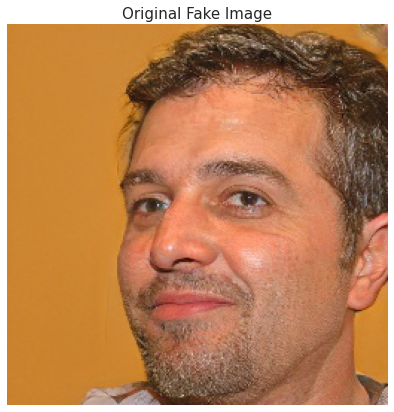

In [310]:
plt.figure(figsize=(7, 7))
plt.title('Original Fake Image', fontsize=15)
plt.imshow(img)
plt.grid(False)
plt.axis(False)
plt.show()

### Saliency Mapping

In [311]:
def get_saliency(img, model):
    model.eval()
    img.requires_grad = True
    output = model(img)
    output[0].backward()
    saliency, _ = torch.max(img.grad.data.abs(), dim=1) 
    return saliency.cpu(), output.cpu().item()

In [312]:
res_resized_img = np.asarray(T.Resize([224, 224])(img))
res_trans_img = test_res_ds.transform_img(img)
res_trans_img = res_trans_img.unsqueeze(0)
res_trans_img = res_trans_img.to(device)

weights = torch.load(FT_RESNET_FL_WEIGHT_PATH)
ft_res_classifier.load_state_dict(weights)
ft_res_classifier.to(device)
ft_res_classifier.eval()

res_saliency, res_score = get_saliency(res_trans_img, ft_res_classifier)
res_saliency = res_saliency.reshape(224, 224)

In [313]:
incep_resized_img = np.asarray(T.Resize([299, 299])(img))
incep_trans_img = test_incep_ds.transform_img(img)
incep_trans_img = incep_trans_img.unsqueeze(0)
incep_trans_img = incep_trans_img.to(device)

weights = torch.load(FT_INCEPTION_FL_WEIGHT_PATH)
ft_incep_classifier.load_state_dict(weights)
ft_incep_classifier.to(device)
ft_incep_classifier.eval()

incep_saliency, incep_score = get_saliency(incep_trans_img, ft_incep_classifier)
incep_saliency = incep_saliency.reshape(299, 299)

In [323]:
print('Inception Score: %.3f' % (1-incep_score))
print('ResNet Score: %.3f' % (1-res_score))

Inception Score: 1.000
ResNet Score: 0.667


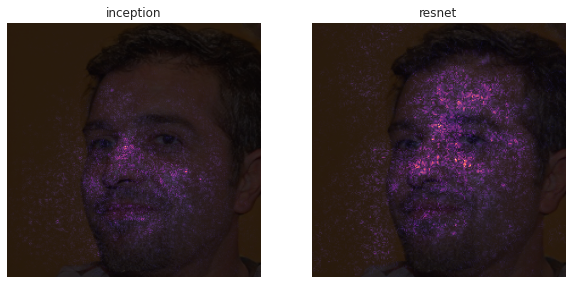

In [316]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))

# inception
ax[0].imshow(incep_resized_img)
ax[0].imshow(incep_saliency.cpu(), cmap='magma', alpha=0.8)
ax[0].title.set_text('inception')
ax[0].grid(False)
ax[0].axis(False)

# resnet
ax[1].imshow(res_resized_img)
ax[1].imshow(res_saliency.cpu(), cmap='magma', alpha=0.8)
ax[1].title.set_text('resnet')
ax[1].grid(False)
ax[1].axis(False)

plt.show()

### Occlusion

In [317]:
occlusion = Occlusion(ft_incep_classifier)
attributions_occ = occlusion.attribute(incep_trans_img,
                                       strides = (3, 5, 5),
                                       sliding_window_shapes=(3,15, 15))
attributions_occ = attributions_occ.squeeze().cpu().detach().numpy()

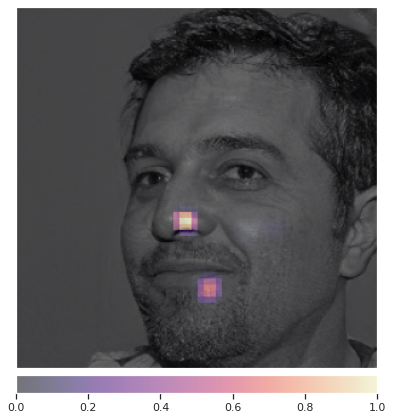

In [318]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ, (1,2,0)),
                                      incep_resized_img,
                                      ["blended_heat_map"],
                                      ["negative"],
                                      cmap='magma',
                                      show_colorbar=True)

In [319]:
occlusion = Occlusion(ft_res_classifier)
attributions_occ = occlusion.attribute(res_trans_img,
                                       strides = (3, 5, 5),
                                       sliding_window_shapes=(3,15, 15))
attributions_occ = attributions_occ.squeeze().cpu().detach().numpy()

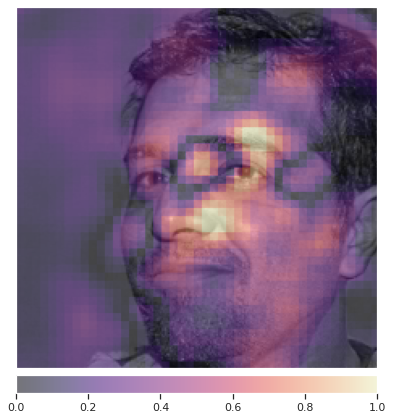

In [320]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ, (1,2,0)),
                                      res_resized_img,
                                      ["blended_heat_map"],
                                      ["negative"],
                                      cmap='magma',
                                      show_colorbar=True)

## Image 2

In [390]:
img, target = test_res_ds.get_fake_img()
label = test_res_ds.decode(target)

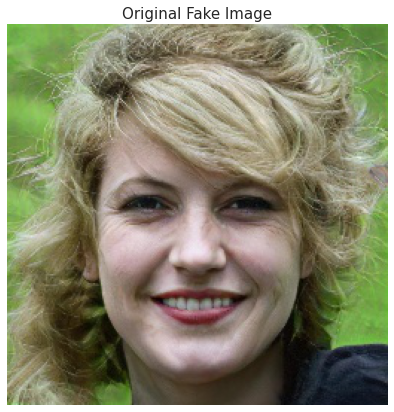

In [391]:
plt.figure(figsize=(7, 7))
plt.title('Original Fake Image', fontsize=15)
plt.imshow(img)
plt.grid(False)
plt.axis(False)
plt.show()

### Saliency Mapping

In [392]:
res_resized_img = np.asarray(T.Resize([224, 224])(img))
res_trans_img = test_res_ds.transform_img(img)
res_trans_img = res_trans_img.unsqueeze(0)
res_trans_img = res_trans_img.to(device)

res_saliency, res_score = get_saliency(res_trans_img, ft_res_classifier)
res_saliency = res_saliency.reshape(224, 224)

In [393]:
incep_resized_img = np.asarray(T.Resize([299, 299])(img))
incep_trans_img = test_incep_ds.transform_img(img)
incep_trans_img = incep_trans_img.unsqueeze(0)
incep_trans_img = incep_trans_img.to(device)

incep_saliency, incep_score = get_saliency(incep_trans_img, ft_incep_classifier)
incep_saliency = incep_saliency.reshape(299, 299)

In [394]:
print('Inception Score: %.3f' % (1-incep_score))
print('ResNet Score: %.3f' % (1-res_score))

Inception Score: 0.226
ResNet Score: 1.000


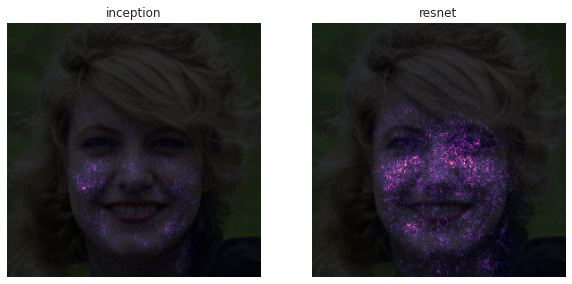

In [395]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))

# inception
ax[0].imshow(incep_resized_img)
ax[0].imshow(incep_saliency.cpu(), cmap='magma', alpha=0.8)
ax[0].title.set_text('inception')
ax[0].grid(False)
ax[0].axis(False)

# resnet
ax[1].imshow(res_resized_img)
ax[1].imshow(res_saliency.cpu(), cmap='magma', alpha=0.8)
ax[1].title.set_text('resnet')
ax[1].grid(False)
ax[1].axis(False)

plt.show()

## Occlusion

In [396]:
occlusion = Occlusion(ft_incep_classifier)
attributions_occ = occlusion.attribute(incep_trans_img,
                                       strides = (3, 5, 5),
                                       sliding_window_shapes=(3,15, 15))
attributions_occ = attributions_occ.squeeze().cpu().detach().numpy()

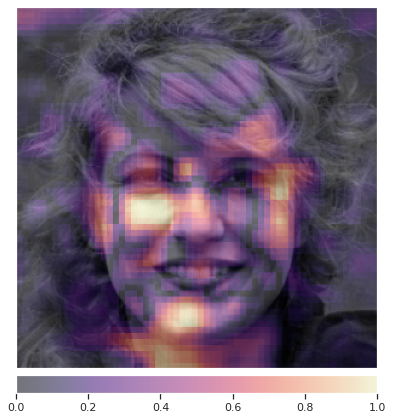

In [397]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ, (1,2,0)),
                                      incep_resized_img,
                                      ["blended_heat_map"],
                                      ["negative"],
                                      cmap='magma',
                                      show_colorbar=True)

In [398]:
occlusion = Occlusion(ft_res_classifier)
attributions_occ = occlusion.attribute(res_trans_img,
                                       strides = (3, 5, 5),
                                       sliding_window_shapes=(3,15, 15))
attributions_occ = attributions_occ.squeeze().cpu().detach().numpy()

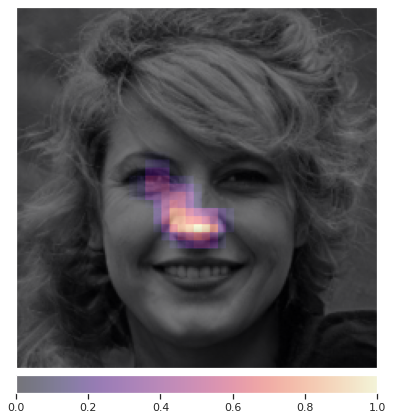

In [399]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ, (1,2,0)),
                                      res_resized_img,
                                      ["blended_heat_map"],
                                      ["negative"],
                                      cmap='magma',
                                      show_colorbar=True)